# 使用字符级 RNN 对名字进行分类

**作者**: [Sean Robertson](https://github.com/spro/practical-pytorch)


我们将构建以及训练一个基础的字符级 RNN 来对单词进行分类。
字符级 RNN 将单词作为字符序列读取——在每个步骤都输出预测和“隐藏层”，然后将上一步的隐藏状态输入到下一步。
我们采用最终的预测作为输出，即单词属于哪个分类。

具体来说，我们使用来自18种语言的几千个姓氏进行训练，并根据拼写预测名字来自那种语言：

```console
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

**推荐阅读：**

假设您至少安装了 PyTorch，了解 Python，且理解张量：

- https://pytorch.org/: 有关于安装说明
- :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
- :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
- :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

了解 RNN 及其工作方式是也是很有用的：

- [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
  展示了一系列现实生活中的例子
- [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
  它是特别针对 LSTM 的，但也提供了关于 RNN 的一般信息

## 准备数据

!!!note

    从 <https://download.pytorch.org/tutorial/data.zip> 下载数据，并解压到当前目录。

`data/names`子目录中有18个文本文件，文件名的格式是"[language].txt"。
每个文件包含许多名字，每个名字一行。这些名字字符主要是罗马化的（但我们仍然需要将它们从 Unicode 转为 ASCII）。

最终得到一个“语言=>名字列表”字典，形如 `{language: [names ...]}`。
通用变量 "category" 和 "line"（在本例中用于表示语言和名字）对以后的扩展有用。

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']
Slusarski


现在我们有了变量 `category_lines`, 它是一个映射每一类型（语言）与行列表（名字）的字典。
我们还得到了变量 `all_categories`（仅是语言列表）与 `n_categories` 共以后使用。




In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### 将名字转换为张量

现在我们已经组织好了所有的名字，还需要把他们转为张量才能使用。

我们使用大小为 `<1 x n_letters>` 的“独热（on-hot）向量”表征一个字母。
独热向量中除了当前字母位置是1,其它都用0填充，比如 `"b" = <0 1 0 0 0 ...>`。

我们将这样的向量组合成形状为 `<line_length x 1 x n_letters>` 2维矩阵，就形成了一个单词。

额外的1维是因为PyTorch假定所有东西都是批量的 - 我们这里使用批量大小正好是1。




In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## 创建网络

在 autograd 之前，在 Torch 中创建一个递归神经网络涉及到在个时间步骤内克隆一个层的参数。
这些保持着隐藏状态和梯度的层，现在就被完全由交由图自身处理了。

这个 RNN 模型（主要从 <https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net> 复制），
只有2个线性层，对输入和隐藏状态进行运算，在输出后有一个 LogSoftmax 层。

![](https://i.imgur.com/Z2xbySO.png)


In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

要运行这个网络的一个步骤，我们需要传入一个输入（本例中，输入是当前字母的张量）和一个之前的隐藏状态（第一个代码块中用零初始化的）。
我们将得到输出值（每种语言的概率）和下一个隐藏状态（我们为下一个步骤保留它）。




In [5]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

为了提高效率，我们不希望为每一步创建新的 `Tensor`，因此我们将使用 `lineToTensor` 而不是 `letterToTensor`，并使用切片。这可以通过预先计算批量 `Tensors` 达成进一步优化。



In [6]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8252, -2.9202, -2.8685, -2.8023, -2.9007, -2.9530, -2.9002, -2.8764,
         -2.9512, -2.9461, -2.8628, -2.9676, -2.8661, -2.9226, -2.9126, -2.8640,
         -2.8239, -2.8826]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




## 训练

### 准备训练

在进入训练之前，我们应该做编写一些辅助函数。
第一个是解释网络的输出，让我们直到每个类别的似然度。
我们可用 `Tensor.topk` 获取最大值的索引。

In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Dutch', 3)


我们还需要能够快速的得到训练样本(名字及其语言)的函数：




In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Stroggylis
category = Italian / line = Nicolai
category = Korean / line = Yu
category = French / line = Lebeau
category = Arabic / line = Botros
category = Polish / line = Piatek
category = Dutch / line = Middelburg
category = German / line = Lenz
category = Russian / line = Levish
category = Japanese / line = Onoe


### 训练网络

现在，只要一堆样本就可以训练这个网络了，让它做出猜测，然后告诉它是对是错。

因为 RNN 的最后一层是 `nn.LogSoftmax`，损失函数 `nn.NLLLoss` 是合适的。




In [9]:
criterion = nn.NLLLoss()

每一轮训练都将：

- 创建输入和目标张量
- 创建零值初始化的隐藏状态
- 读取每个字母，并
    - 为下个字母保留隐藏状态
- 比较最终输出和目标
- 反向传播
- 返回输出和损失




In [10]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

现在，我们只需用这一堆样本来运行训练。
由于样本有 100 个，我们每 `print_every` 次只打印一个样本，取一次损失平均值。




In [11]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.4106 Hamilton / Russian ✗ (Scottish)
10000 10% (0m 14s) 1.5545 Thach / Vietnamese ✓
15000 15% (0m 21s) 0.1816 Bouloukos / Greek ✓
20000 20% (0m 27s) 0.4047 Babenchikov / Russian ✓
25000 25% (0m 34s) 2.0310 Black / Scottish ✓
30000 30% (0m 41s) 4.2426 Budny / Scottish ✗ (Polish)
35000 35% (0m 48s) 0.8464 Sayegh / Arabic ✓
40000 40% (0m 54s) 2.0331 Szewc / Korean ✗ (Polish)
45000 45% (1m 1s) 0.9588 Cao / Chinese ✗ (Vietnamese)
50000 50% (1m 8s) 2.1418 Young / Chinese ✗ (Scottish)
55000 55% (1m 15s) 1.4259 Rocha / Portuguese ✗ (Spanish)
60000 60% (1m 22s) 1.3695 Totah / Arabic ✓
65000 65% (1m 29s) 0.1202 Alberghi / Italian ✓
70000 70% (1m 36s) 2.0509 Bang / Chinese ✗ (Korean)
75000 75% (1m 43s) 3.0517 Koemans / Greek ✗ (Dutch)
80000 80% (1m 50s) 0.5485 Ganim / Arabic ✓
85000 85% (1m 57s) 3.0609 Lee / Chinese ✗ (Korean)
90000 90% (2m 4s) 0.7343 Perez / Spanish ✓
95000 95% (2m 12s) 1.0694 Ahn / Korean ✓
100000 100% (2m 18s) 2.9015 Raine / French ✗ (English)


### 绘制结果

从 `all_losses` 绘制损失历史，展示网络的学习情况：




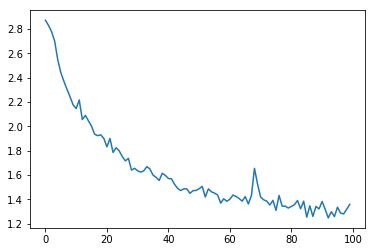

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

## 评估结果

为了了解网络在不同类别上的表现，我们将创建一个混淆矩阵，记录每个每个实际语言（行）被网络猜测成了哪个语言（列）。
为了计算混淆矩阵，将一组样本传入网络，执行 `evaluate()`，它相当于去掉反向传播的`train()`。



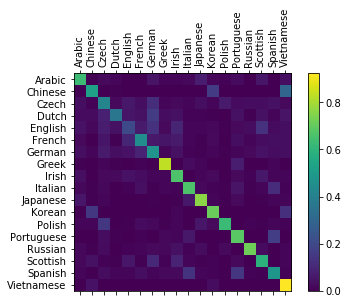

In [15]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

我们可以上找出预测错误的亮点，它表明哪些语言被错误的猜测为其它语言，如汉语与高丽语，西班牙语与意大利语。
看起来，它对希腊语效果很好，对英语的效果很可怜（可能是因为英语的名字与其它语言的相覆盖）。




## 对用户输入进行预测




In [16]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.71) Russian
(-1.14) Czech
(-2.49) English

> Jackson
(-0.06) Scottish
(-3.47) English
(-4.72) Russian

> Satoshi
(-0.98) Japanese
(-1.36) Italian
(-2.01) Arabic


The final versions of the scripts `in the Practical PyTorch
repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
split the above code into a few files:
文中这些代码块的最终版本在 [in the Practical PyTorch repo](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification)
上面的代码被划分到了几个不同文件：

- `data.py` (加载文件)
- `model.py` (定义 RNN)
- `train.py` (运行训练)
- `predict.py` (用命令行参数运行 `predict()`)
- `server.py` (用 `bottle.py` 运行 JSON API 预测服务)

执行 `train.py` 训练和保存网络。

执行 `predict.py` 预测名字的预测：

```console
$ python predict.py Hazaki
(-0.42) Japanese
(-1.39) Polish
(-3.51) Czech
```

执行 `server.py` 然后访问 <http://localhost:5533/Yourname> 获得 JSON 预测结果。




## 练习

- 尝试不同的 “行 -> 分类” 数据集，例如:
    - 任何单词 -> 语言
    - 名字 -> 性别
    - 角色的名字 -> 作者
    - 论文票提 -> blog 还是 reddit
- 用更大或者形状更好的网络获得更好的结果
    - 增加更多的线性层
    - 尝试使用 `nn.LSTM` 和 `nn.GRU` 层
    - 将这些 RNN 组合成更高级别的网络


